In [ ]:
%pip install qiskit ipywidgets
%pip install matplotlib

In [ ]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
#from qiskit.primitives 
from qiskit import Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import qiskit.tools.jupyter
%qiskit_version_table
vers_qis = qiskit.__qiskit_version__['qiskit']
SAMPLING = False

In [ ]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

In [ ]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

In [ ]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], 0, q_reg)
circ.draw()

In [ ]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()

In [ ]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], q_reg)
circ.draw()

In [ ]:
# Implements the entire cost function on the quantum circuit

# number of shots to use in circuit for sampling
SHOTS = 100000

def calculate_cost_function(parameters):
    
    global opt,current_cost

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9] ]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            if SAMPLING:
               qc = ClassicalRegister(1)
            else:
              qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('aer_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j] ], [1, 2, 3], 0, parameters)

            if SAMPLING:
              circ.measure(0,0)
            else:
              circ.save_statevector()

            t_circ = transpile(circ, backend)

            if SAMPLING:
              qobj = assemble(t_circ,  shots=SHOTS )
            else:
              qobj = assemble(t_circ)
            

            job = backend.run(qobj)
            
            result = job.result()

            if SAMPLING:
              outputstate = result.get_counts(circ)
            else:
              outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            
            if SAMPLING:
              if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/SHOTS
              else:
                 m_sum = 0
            
            else:
              m_sum = 0
              for l in range (0, o.size):
                  if (l%2 == 1):
                      n = o[l]**2
                      m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                if SAMPLING:
                   qc = ClassicalRegister(1)
                else:
                  qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                if SAMPLING:
                   circ.measure(0,0)
                else:
                  circ.save_statevector()
                
                t_circ = transpile(circ, backend)
                
                if SAMPLING:
                   qobj = assemble(t_circ, shots=SHOTS)
                else:
                  qobj = assemble(t_circ)
                
                job = backend.run(qobj, )
                  
                result = job.result()

                if SAMPLING:
                  outputstate = result.get_counts(circ)
                else:
                  outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                if SAMPLING:
                   if ('1' in outputstate.keys()):
                      m_sum = float(outputstate["1"])/SHOTS
                   else:
                      m_sum = 0
                else:
                  m_sum = 0
                  for l in range (0, o.size):
                      if (l%2 == 1):
                          n = o[l]**2
                          m_sum+=n
                
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))
    current_cost = 1-float(overall_sum_2/overall_sum_1)

    #return 1-float(overall_sum_2/overall_sum_1)
    return current_cost

In [ ]:
# creating and storing random k, for later reproduceability
k  = [float(random.randint(0,3000))/1000 for i in range(0, 9)]

In [22]:
def log_cost(x):
  cost_values.append(current_cost)

optimizers = ["COBYLA", "CG", "BFGS", "L-BFGS-B", "SLSQP", ]

coefficient_set = [0.55, 0.45]
gate_set = [ [0, 0, 0], [0, 0, 1] ]

max_iter = 200
cost_sum = np.zeros((len(optimizers), max_iter+1))
opt_iter = 1
nqubits = 3
anci_bits = 3

accuracy = []

for j in range(opt_iter):
  for i in range(len(optimizers)):
    cost_values = [] 
    out = minimize(calculate_cost_function, x0=k, method=optimizers[i], options={'maxiter':max_iter}, callback=log_cost)
    print(out)

    proper_index = 0
    for element in np.array(cost_values):
      cost_sum[i][proper_index] += element
      proper_index += 1
    
    out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9] ]

    circ = QuantumCircuit(nqubits, anci_bits)
    apply_fixed_ansatz([0, 1, 2], out_f)

    circ.save_statevector()

    backend = Aer.get_backend('aer_simulator')
    t_circ = transpile(circ, backend)
    qobj = assemble(t_circ)
    job = backend.run(qobj)

    result = job.result()
    o = result.get_statevector(circ, decimals=10)

    #a1 = coefficient_set[1]*np.array([ [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1] ])
    #a2 = coefficient_set[0]*np.array([ [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1] ])
    #b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

    Z = np.array([[1,0], [0,-1]])
    I = np.identity(2)
    a2 = coefficient_set[0]*np.identity(2**nqubits)
    a1 = coefficient_set[1]*np.kron(np.kron(Z,I),I)
    b = np.ones(2**nqubits)/np.sqrt(2**nqubits)

    a3 = np.add(a1, a2)

    accuracy_result = (b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2
    print(accuracy_result)
    accuracy += [accuracy_result]


0.3658828038247567
0.36588281500477216
0.3658828145583215
0.36588280675461826
0.3658828107037928
0.3658828067726856
0.34478121693395747
0.3447812158648562
0.34478121518768123
0.34478121698929043
0.34478121210071955
0.3447812243213504
0.3447812232857139
0.34478121517577176
0.34478121901792413
0.34478121524136873
0.2968863167502116
0.2968863062817829
0.2968863134065689
0.2968863138718685
0.2968863135873069
0.2968863325602825
0.29688632360120404
0.296886316201865
0.2968863195462028
0.29688632396736003
0.2997914643456784
0.29979146016365155
0.29979146177892035
0.29979146300742576
0.29979146014222635
0.29979147605034195
0.2997914716830733
0.29979146321300365
0.29979146678283275
0.299791465397779
0.29312103200131545
0.2931210246477076
0.29312102897861325
0.2931210297876826
0.2931210283671747
0.29312104614540657
0.29312103925857524
0.2931210312042616
0.2931210346471641
0.2931210361190044
0.3540377443322291
0.35403771073507084
0.3540377430644255
0.35403774144624645
0.3540377611670803
0.3540377

C:\Users\fouad\AppData\Local\Temp\ipykernel_18580\3386136870.py:45: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
C:\Users\fouad\AppData\Local\Temp\ipykernel_18580\3386136870.py:107: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj, )


5.780259937360199e-09
5.7804460107391265e-09
5.779520639848101e-09
5.780528389287554e-09
5.780444234382287e-09
5.78013104046704e-09
5.7797455710328904e-09
5.780148581990829e-09
5.780986689352119e-09
5.780080303274815e-09


C:\Users\fouad\AppData\Local\Temp\ipykernel_18580\3386136870.py:45: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
C:\Users\fouad\AppData\Local\Temp\ipykernel_18580\3386136870.py:107: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj, )


2.033588963890054e-08
2.0333898453905874e-08
2.0335415240602117e-08
2.033391810485341e-08
2.0332182049109804e-08
2.0336029193934735e-08
2.03491563599556e-08
2.033558899050547e-08
2.0336392236863787e-08
2.0337885819898815e-08
5.2135188388646725e-09
5.213306120133154e-09
5.212809628396542e-09
5.2134432326766955e-09
5.2130759709001495e-09
5.213405374071556e-09
5.2152233642743795e-09
5.213382281432644e-09
5.214212728255063e-09
5.213688147875928e-09
4.16972589789566e-09
4.1694894203914146e-09
4.169114831142906e-09
4.1696348596076405e-09
4.169284362198766e-09
4.169676826037971e-09
4.171145762121853e-09
4.169617318083851e-09
4.1703559494621345e-09
4.169983469637373e-09
1.6558433513225168e-09
1.655365955421928e-09
1.6554803083934644e-09
1.6557151205631726e-09
1.6554158044357337e-09
1.655780290654718e-09
1.6560192106496174e-09
1.6558951987377668e-09
1.6562330396041602e-09
1.6563425075943883e-09
3.6756444776742114e-08
3.676841198174685e-08
3.675624860033366e-08
3.6756980015262286e-08
3.676637305

C:\Users\fouad\AppData\Local\Temp\ipykernel_18580\2778131253.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


0.6168373175291255
0.6168373165385937
0.6168373195324988
0.6168373172964362
0.6168373179636789
0.6168373151599607
0.6168373150173587
0.6168373170810117
0.6168373155721989
0.6168373184412212
0.5401659776494314
0.5401659773248466
0.5401659786057349
0.5401659774102711
0.5401659778315271
0.5401659763588138
0.5401659760437633
0.5401659767223004
0.5401659770657019
0.5401659775201731
0.5074492288987983
0.507449229122328
0.5074492283142108
0.507449228833438
0.5074492289986483
0.5074492294549172
0.507449228342725
0.5074492279479332
0.507449230118673
0.5074492276662489
0.4919126590542555
0.49191265933405615
0.4919126587432813
0.4919126589193338
0.49191265938775575
0.4919126594595704
0.49191265851408406
0.491912658356199
0.49191266004250145
0.49191265809745444
0.4650433220076744
0.465043322432214
0.46504332195501397
0.46504332189159203
0.4650433227693731
0.46504332222015754
0.46504332169234486
0.4650433217037422
0.4650433226989441
0.46504332128840575
0.42509617668363575
0.42509617702730296
0.4250

Starting  with k = : [1.86, 2.243, 1.924, 2.744, 3.0, 0.502, 1.589, 0.229, 0.158]


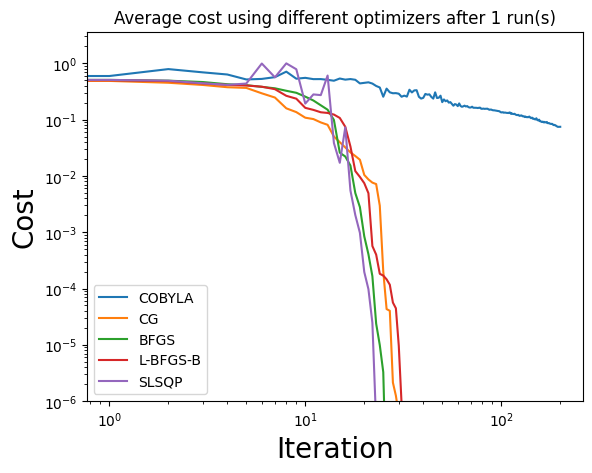

Accuracy with COBYLA: (0.9256678836615438-0j)
Accuracy with CG: (0.9999999999566884-0j)
Accuracy with BFGS: (0.9999999999951117-0j)
Accuracy with L-BFGS-B: (0.9999999998015081-0j)
Accuracy with SLSQP: (0.9999998801751198-0j)


In [23]:
#IND determines whether to print each graph individually
IND = False

for i in range(len(optimizers)):
    plt.loglog(cost_sum[i]/opt_iter)
    if IND: 
        plt.ylim(math.pow(10,-6))
        plt.legend([optimizers[i]])
        plt.show()

plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.ylim(math.pow(10,-6))
plt.legend(optimizers)
plt.title("Average cost using different optimizers after " + str(opt_iter) + " run(s)")

# Seed:
print("Starting  with k = : " + str(k))
plt.show()

for i in range(len(optimizers)):
    print("Accuracy with " + optimizers[i] + ": " + str(accuracy[i]))